# Большая домашка 1: сегментация 

Товарищи, мы все уже великие специалисты в нейронных сетях, поэтому пришло время показать это миру. Мы будем решать конкурс от роснефти по сегментации изображений. У нас будут изображения с трехмерного куба, где надо найти различные области на этих снимках. А дальше уже смотрите сами :)

Более подробно о данном конкурсе можно посмотреть [вот тута](https://boosters.pro/championship/seismic_challenge/overview)

В рамках данной домашки попробуем вспомнить все, что нам мы делали. Дальше будет о подгрузке данных и небольшие направления деятельности, но в основном ваше фантазия решает этот конкурс :)

In [2]:
import tensorflow as tf
# import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import cv2 # подгрузка и работа с данными
import os
import tqdm # счетчик и красивый прогресс бар

In [3]:
IMAGE_PATH = 'data/train/images/'
MASK_PATH = 'data/train/train.csv'
# TEST_PATH = 'data/test/images/'
# SAMPLE_PATH = 'make_rofneft_predict/data/sample_submission.csv'

def rle2mask(mask_rle, shape):
    # эта функция взята с конкурса и я её оставил как есть
    """
    mask_rle: run-length as string formated (start length)ы
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    if mask_rle != mask_rle:
        return np.zeros_like(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [4]:
class TrainDataset():
    # немного переписанный загрузчик данных опять же с конкурса
    def __init__(self, image_dir, train):
        self.image_dir = image_dir
        self.train = train

    def __getitem__(self, index):
        img_name = self.train.iloc[index]['ImageId']
        path = os.path.join(self.image_dir, img_name)
        img = cv2.imread(path)
        img = cv2.resize(img,(384,384))

        ce_mask = [
            (i + 1) * rle2mask(rle, shape=(img.shape[0], img.shape[1])) \
                for i, rle in enumerate(self.train[self.train['ImageId']==img_name]['EncodedPixels'])
        ]
        ce_mask = np.sum(ce_mask, axis=0, dtype=np.float32)


        result = {
            'image':img, 
            'mask': ce_mask,
            'pick_name':img_name
        }
        return result
    
    def __len__(self, ):
        return len(self.train)

In [5]:
train = pd.read_csv(MASK_PATH)

train_dataset = TrainDataset(
    image_dir=IMAGE_PATH, 
    train=train)

Кстати, посмотрев на данные, какие особенности данных мы видим?

In [6]:
from tqdm import tqdm

In [7]:
x_images = []
y_images = []
name_images = []
for i in tqdm(range(len(train_dataset))):
    slice_step = train_dataset[i]
    if 'inline' in slice_step['pick_name']:
        pickk_name = 'inline'
    else:
        pickk_name = 'xline'
    name_images.append(pickk_name)
    x_images.append(slice_step['image'][:,:,0])
    y_images.append(slice_step['mask']) 

100%|██████████████████████████████████████████████████████████████████████████████| 6272/6272 [01:18<00:00, 80.37it/s]


In [8]:
x_images = np.array(x_images)
x_images_norm = x_images/255
y_images = np.array(y_images,dtype=np.int)

In [75]:
# ## проверка на нужность каналов
# list_sample_true = []
# for sample_pic in tqdm.tqdm(x_images):
#     list_sample_true.append(np.sum(sample_pic[:,:,0]==sample_pic[:,:,2]))
    
    


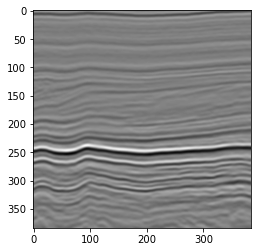

In [93]:
plt.imshow(x_images[0],cmap='gray')

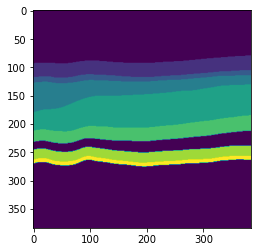

In [68]:
plt.imshow(y_images[0])



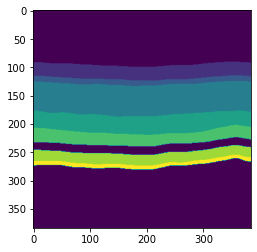

In [83]:
plt.imshow(y_images[3507])

In [82]:
name_images.index('xline')

3507

Такс, что мы хотим делать с данными дальше ? Можем ли мы что-то предположить заранее?

In [ ]:
#### Ваш код игры с данными

В самой задачке на бустере используется метрика dice по границе и всей области.
Мы упростим задачу, просто берем dice по области.

Собственно нам надо реализовать следующую формулу

\begin{equation}
dice = \sum_{k=0}^7(\cfrac{2*|prediction \cap truch|}{|prediction| + |truch|})
\end{equation}

Ну и чтобы в случае чего не делить на ноль, надо добавить небольшой эпсилон к верхней и нижней части.

In [45]:
def dice_metric(y_true, y_pred):
    smooth = 0.00001
    dice_list_value = tf.constant(0.) 
    for val in range(0,8):
        y_true_step = tf.cast((y_true==val),'float32')
        y_pred_step = tf.cast((y_pred==val),'float32')
        intersection = tf.reduce_sum(y_true_step*y_pred_step,axis=(1,2))
        union = tf.reduce_sum(y_true_step,axis=(1,2))+tf.reduce_sum(y_pred_step,axis=(1,2))
        dice = (2*intersection+smooth)/union
        dice_list_value += dice
    return tf.reduce_mean(dice_list_value/8)


Придумываем бейзлайн для всего нашего кусочка - должны же мы его превзойти!

In [ ]:
# Код бейзлайна
# Усреднить маски и сравнивать с полученной маской

Ну что же, теперь пришло время к моделям!
Начнем с простой модельки - fully-convolution-net.

И да - архитектура на ваш вкус и цвет :)

Но прежде чем начинать, какие callback нам точно потребуются? (вне зависимости от архитектуры)

In [ ]:
# Собираем fully-convolution-net

Собираем u-net. Смотрим как оно :)

In [ ]:
# Собираем u-net

Ну чтож, время вашего творчества - меняем архитектуры, смотрим и вспоминаем, что же ещё мы не учли и что может нам помочь. Да и вообще -какие подходы ещё не использованы! Ещё имеет смысл попробовать transfer learning!

In [ ]:
### играемся на все деньги

И доп задачка для всех - а что если обучить часть (или весь) unet как автоэнкодер...


In [ ]:
##############################